# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD)    (Note: Also called FISTA in the lecture slides!)

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- Since many students are not currently registered on moodle, we are still choosing how you will submit the final notebook. We will e-mail you before **1st of  October** on how to submit the final notebook.
- Deadline for submission is the **4th of october at 21:59**
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [32]:
# Change here using YOUR first and last names
fn1 = "Michail"
ln1 = "Thomas"
fn2 = "Aristotelis"
ln2 = "Koen"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_thomas_michail_and_koen_aristotelis.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import  scipy.optimize as optim
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

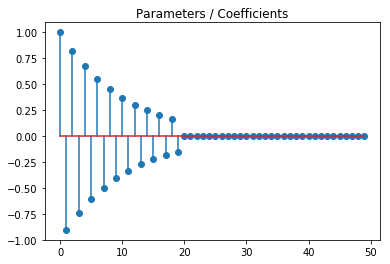

In [7]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [8]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [33]:
#A, b = simu_linreg(coefs);

A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course (using separability) or find a smart way to rewrite it in one line with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [10]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x) * np.maximum(np.abs(x) - lmbd, 0.) # TODO
    return z

def L1_pen(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x,1) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = x*(1/(1+lmbd)) # TODO
    return z

def L2_pen(x, lmbd):
    """Value of the L2 penalization at x"""
    return (lmbd/2)*np.linalg.norm(x,2)**2 # TODO

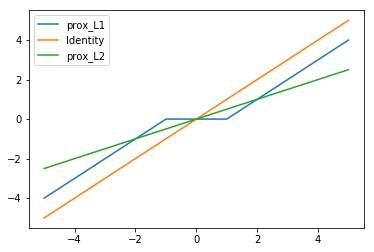

In [11]:
# Plots TODO
x_r = np.linspace(-5,5,1000)
lmbd = 1
plt.figure()
plt.plot(x_r,prox_L1(x_r,lmbd),label = "prox_L1")
plt.plot(x_r,x_r,label="Identity")
plt.plot(x_r,prox_L2(x_r,lmbd),label = "prox_L2")
plt.legend()


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

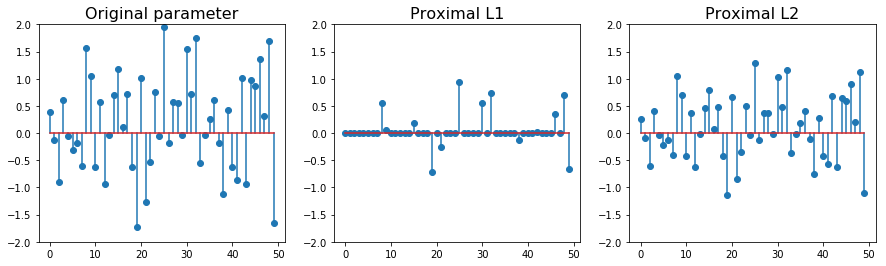

In [12]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

As we know, the penalisation restricts the values of the norm of x. We can observe that both the L1 and L2 penalizors shrink the values of the coefficients. The L1 penalization shrinks the coefficients more than the L2 penalizor.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [34]:
def f_linreg(x):
    """Least squares loss"""
    return (0.5/n_samples)*np.linalg.norm(b-A@x,2)**2

def grad_f_linreg(x):
    """Least squares gradient"""
    return -(1/n_samples)*(np.transpose(A)@(b-A@x))

def f_logreg(x):
    """Logistic loss"""
    loss= 0
    for i in range(n_samples):
      loss += np.log(1+ np.exp(-b[i]*(A[i,:]@x)))
    return (1/n_samples)*loss

def grad_f_logreg(x):
    """Logistic gradient"""
    grad = np.zeros(n_features)
    for i in range(n_samples):
      grad += -(b[i]*A[i,:])*np.exp(-b[i]*(A[i,:]@x))/(1+np.exp(-b[i]*(A[i,:]@x)))
    return (1/n_samples)*grad

print(optim.check_grad(f_linreg,grad_f_linreg,x))
print(optim.check_grad(f_logreg,grad_f_logreg,x))


1.9958850196403025e-06
1.6005202601386076e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

In [14]:
# TO BE COMPLETED

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    #A= np.array(A)
    L=(1/n_samples)*np.linalg.norm(A,2)*np.linalg.norm(A,2)
    return L

# Calculate the smoothness constant for logistic loss    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return 0.25*(1/n_samples)*np.linalg.norm(A,2)*np.linalg.norm(A,2)
        
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
      ### Code the update x= x + ???
      x = prox_R(x-step*grad_f(x),lmbd)
      ##############
      obj = f(x) + R(x, lmbd)
      err = norm(x - x_true) / norm(x_true)
      errors.append(err)
      objectives.append(obj)
      if k % 10 == 0 and verbose:
          print(' | '.join([("%d" % k).rjust(8), 
                            ("%.10e" % obj).rjust(8), 
                            ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [15]:
# TO BE COMPLETED
""" Also called FISTA in the lecture slides """
def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    beta=1
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    for k in range(n_iter + 1):
        ### Code the update of the iterates x and z
        x_new = prox_R(z-step*grad_f(z),lmbd)
        beta_new = (1 + np.sqrt(1 + 4*np.square(beta)))/2
        z = x_new + ((beta-1)/(beta_new))*(x_new - x)
        x= x_new
        beta = beta_new
        ###############
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.10e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [35]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

steplin = 1/(smoothness_const_linreg(A))
steplog = 1/(smoothness_const_loreg(A))

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

[ 0.96 -0.84  0.68 -0.55  0.45 -0.5   0.5  -0.36  0.36 -0.33  0.32 -0.24
  0.27 -0.2   0.14 -0.13  0.09 -0.13  0.15 -0.13 -0.    0.   -0.   -0.
 -0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.   -0.   -0.
  0.   -0.01 -0.   -0.    0.   -0.    0.    0.03  0.01 -0.01  0.    0.
 -0.   -0.  ]


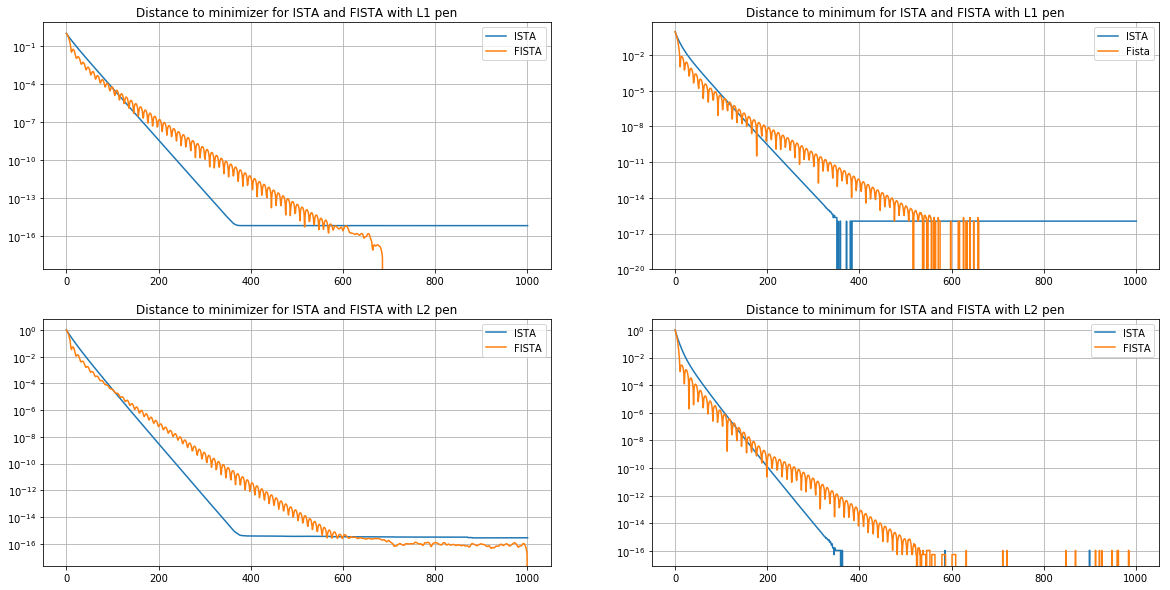

In [17]:
#### LINEAR REGRESSION ####
## L1 PEN ##
xx,oo,ee=APGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=coefs, verbose=False)
xx1, oo1,ee1 = PGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=xx, verbose=False)
xx2, oo2,ee2 = APGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=xx, verbose=False)


## L2 PEN ##
xx_L2,oo_L2,ee_L2=APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=coefs, verbose=False)
xx1_L2, oo1_L2,ee1_L2 = PGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=xx_L2, verbose=False)
xx2_L2, oo2_L2,ee2_L2 = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=xx_L2, verbose=False)

## L1 PEN ##
plt.figure(figsize=[20,10])
plt.subplot(2,2,1)
plt.grid()
plt.title("Distance to minimizer for ISTA and FISTA with L1 pen")
plt.semilogy(ee1,label="ISTA")
plt.semilogy(ee2,label= "FISTA")
plt.legend()


plt.subplot(2,2,2)
plt.grid()
plt.title("Distance to minimum for ISTA and FISTA with L1 pen")
plt.semilogy(abs(oo1-oo[-1]),label="ISTA")
plt.semilogy(abs(oo2-oo[-1]),label= "Fista")
plt.ylim(bottom = 1e-20)
plt.legend()

## L2 PEN ##

plt.subplot(2,2,3)
plt.grid()
plt.title("Distance to minimizer for ISTA and FISTA with L2 pen")
plt.semilogy(ee1_L2,label="ISTA")
plt.semilogy(ee2_L2,label= "FISTA")
plt.legend()


plt.subplot(2,2,4)
plt.grid()
plt.title("Distance to minimum for ISTA and FISTA with L2 pen")
plt.semilogy(abs(oo1_L2-oo_L2[-1]),label="ISTA")
plt.semilogy(abs(oo2_L2-oo_L2[-1]),label= "FISTA")
plt.legend()


We observe that Ista converges faster than Fista until around more than 150 iterations. However, after this point, the ISTA algorithm seems to converge faster.  In fact, we can observe that the L1 penalty converges at around 400 iterations while the FISTA converges in around 600 iterations. Also we can see the ISTA algorithm stalling at a precision of the order of 10^-15 while the FISTA algorithm seems to get closer to the minimizer (see distance to the minimizer for both penalties)

This is quite unexpected as we know from the theory that ista converges in O(1/T) and FISTA converges in O(1/T^2).  

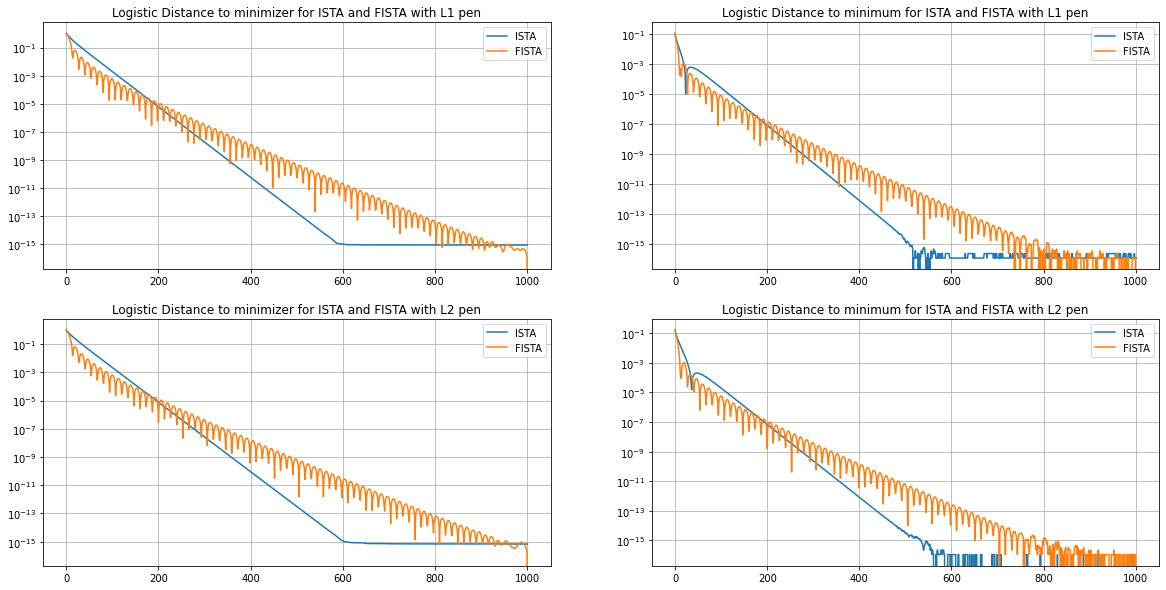

In [130]:
#### LOGISTIC REGRESSION PLEASE CHANGE VALUES OF A and b before running!!!! ####
### L1 PEN ###
xx_log_L1,oo_log_L1,ee_log_L1=APGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=coefs, verbose=False)
xx1_log_L1, oo1_log_L1,ee1_log_L1 = PGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=xx_log_L1, verbose=False)
xx2_log_L1, oo2_log_L1,ee2_log_L1 = APGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=xx_log_L1, verbose=False)

### L2 PEN ###
xx_log, oo_log, ee_log = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=coefs, verbose=False)
xx1_log, oo1_log,ee1_log = PGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=xx_log, verbose=False)
xx2_log, oo2_log,ee2_log = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=xx_log, verbose=False)

### L1 PEN ###
plt.figure(figsize=[20,10])
plt.subplot(2,2,1)
plt.grid()
plt.title("Logistic Distance to minimizer for ISTA and FISTA with L1 pen")
plt.semilogy(ee1_log_L1,label="ISTA")
plt.semilogy(ee2_log_L1,label= "FISTA")
plt.legend()

plt.subplot(2,2,2)
plt.grid()
plt.title("Logistic Distance to minimum for ISTA and FISTA with L1 pen")
plt.semilogy(abs(oo1_log_L1-oo_log_L1[-1]),label="ISTA")
plt.semilogy(abs(oo2_log_L1-oo_log_L1[-1]),label= "FISTA")
plt.legend()

## L2 PEN ##
plt.subplot(2,2,3)
plt.grid()
plt.title("Logistic Distance to minimizer for ISTA and FISTA with L2 pen")
plt.semilogy(ee1_log,label="ISTA")
plt.semilogy(ee2_log,label= "FISTA")
plt.legend()

plt.subplot(2,2,4)
plt.grid()
plt.title("Logistic Distance to minimum for ISTA and FISTA with L2 pen")
plt.semilogy(abs(oo1_log-oo_log[-1]),label="ISTA")
plt.semilogy(abs(oo2_log-oo_log[-1]),label= "FISTA")
plt.legend()

As in the case of the linear regression, we seem to observe a faster covergence of FISTA until 200 iterations (precision of 10^-4) but then ISTA seems to converge faster for higher precisions. However we can see that FISTA seems to continue getting closer to the minimizer at 1000 iterations, while ISTA seems to stall. 

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

**LINEAR REGRESSION**

**Compare the solution you obtain with ista and fista with the true parameter `coefs` of the model. This can be done with `plt.stem` plots.**


(-2, 2)

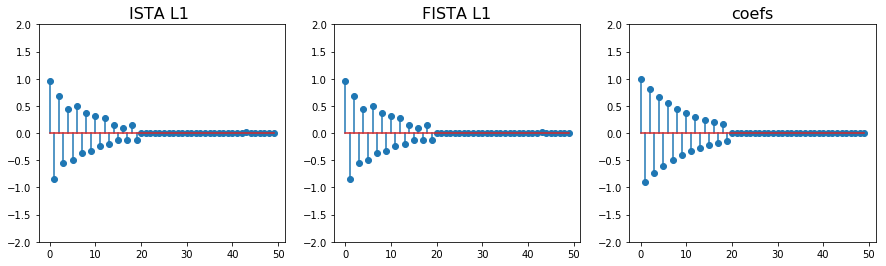

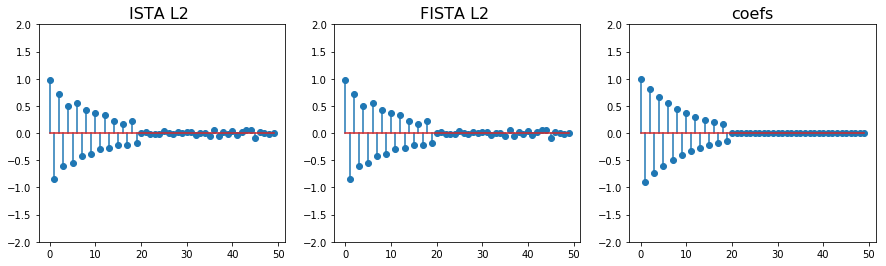

In [18]:
##Compare the solution you obtain with ista and fista with the true parameter `coefs` of the model. This can be done with `plt.stem` plots. ##

## LINEAR REGRESSION ##
### COMPARISON OF COEFS WITH MINIMIZER FOR ISTA FISTA L1 PEN ###
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(xx1)
plt.title("ISTA L1 ", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(xx2)
plt.title("FISTA L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(coefs)
plt.title("coefs", fontsize=16)
plt.ylim([-2, 2])

### COMPARISON OF COEFS WITH MINIMIZER FOR ISTA/FISTA L2 PEN ###
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(xx1_L2)
plt.title("ISTA L2 ", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(xx2_L2)
plt.title("FISTA L2 ", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(coefs)
plt.title("coefs", fontsize=16)
plt.ylim([-2, 2])

We observe that the minimizers obtained by  ISTA and FISTA closely match the coefs value. However, by penalizing with the L1 norm we seem to better approximate the last 20 coordinates which are well shrinked to zero compared to the L2 norm. In fact, we observe that the solutions obtained with the L1 penalization are slightly more shrinked than the L2-penalized solution. 

**Influence of the correlation of features on the performance of ISTA and FISTA (Linear regression):**

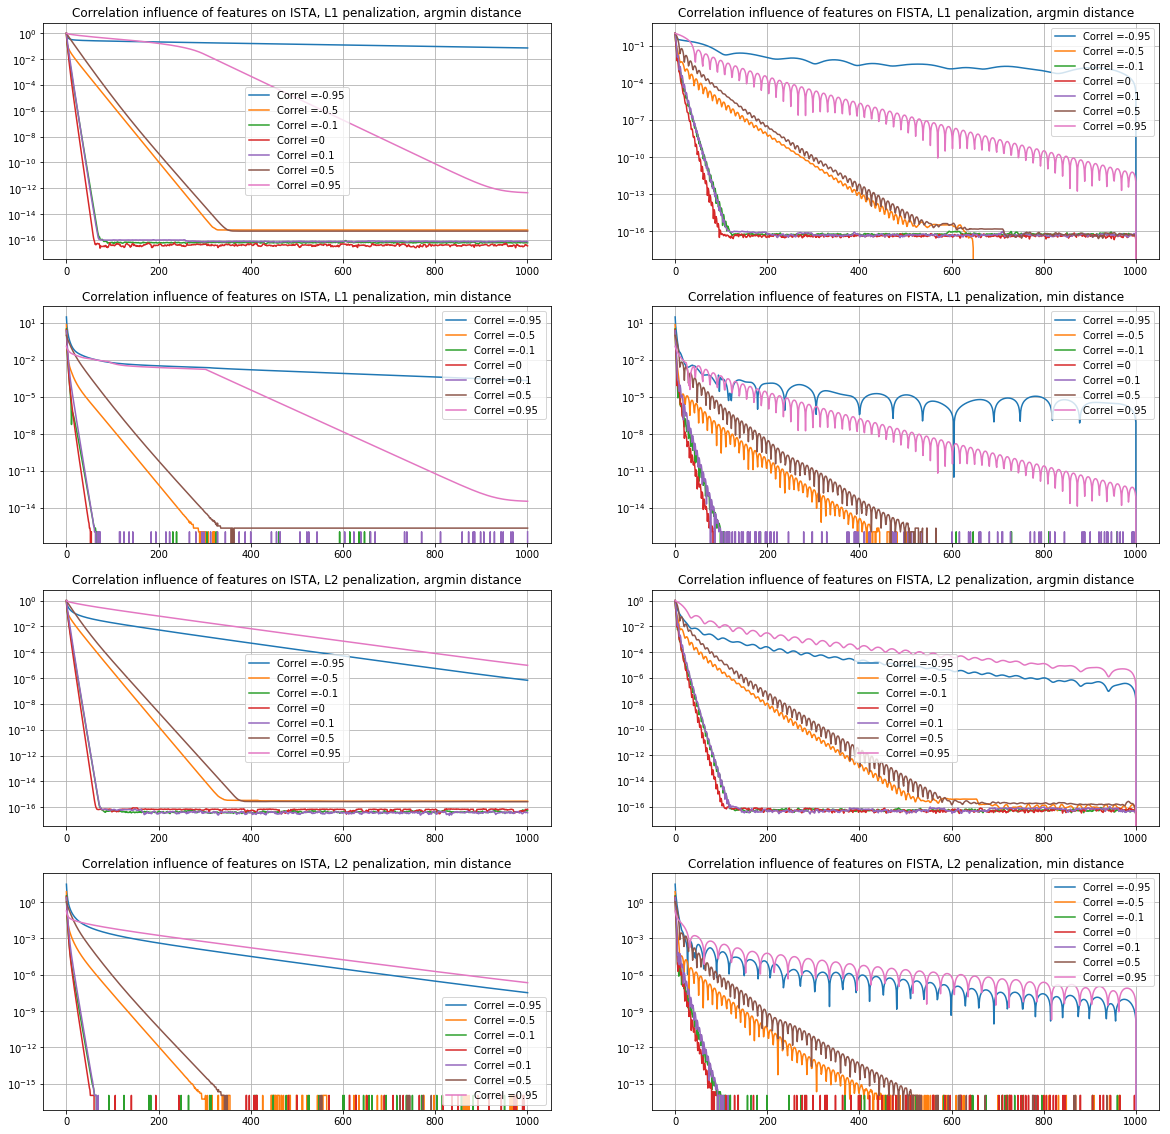

In [19]:
##In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.##
##LINEAR REGRESSION##
def f_linreg(x,A_,b_):
    """Least squares loss"""
    return (0.5/n_samples)*np.linalg.norm(b_-A_@x,2)**2

def grad_f_linreg(x,A_,b_):
    """Least squares gradient"""
    return -(1/n_samples)*(np.transpose(A_)@(b_-A_@x))

#corre = np.linspace(0.05,0.95,9)

corre = [-0.95, -0.5 ,-0.1,0, 0.1 , 0.5 , 0.95]
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2
erreur_lin_ISTA = [] 
erreur_lin_FISTA = []
objec_lin_FISTA = []
objec_lin_ISTA = []

erreur_lin_ISTA_L2 = [] 
erreur_lin_FISTA_L2 = []
objec_lin_FISTA_L2 = []
objec_lin_ISTA_L2 = []
for i in range(len(corre)):
  x0 = np.zeros(n_features)
  A_lin, b_lin = simu_linreg(coefs,corr=corre[i])
  steplin = 1/(smoothness_const_linreg(A_lin))
  x_min_lin, obj_lin, err_lin = APGD(x0, lambda fx:f_linreg(fx,A_lin,b_lin), lambda gradx:grad_f_linreg(gradx,A_lin,b_lin), L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=coefs, verbose=False)
  x_min_lin_1, obj_lin_1, err_lin_1 = PGD(x0, lambda fx:f_linreg(fx,A_lin,b_lin), lambda gradx:grad_f_linreg(gradx,A_lin,b_lin), L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=x_min_lin, verbose=False)
  x_min_lin_2, obj_lin_2, err_lin_2 = APGD(x0, lambda fx:f_linreg(fx,A_lin,b_lin), lambda gradx:grad_f_linreg(gradx,A_lin,b_lin), L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=x_min_lin, verbose=False)
  erreur_lin_ISTA.append(err_lin_1)
  erreur_lin_FISTA.append(err_lin_2)
  objec_lin_FISTA.append(abs(obj_lin_2-obj_lin[-1]))
  objec_lin_ISTA.append(abs(obj_lin_1-obj_lin[-1]))

  x_min_lin_L2, obj_lin_L2, err_lin_L2 = APGD(x0, lambda fx:f_linreg(fx,A_lin,b_lin), lambda gradx:grad_f_linreg(gradx,A_lin,b_lin), L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=coefs, verbose=False)
  x_min_lin_1_L2, obj_lin_1_L2, err_lin_1_L2 = PGD(x0, lambda fx:f_linreg(fx,A_lin,b_lin), lambda gradx:grad_f_linreg(gradx,A_lin,b_lin), L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=x_min_lin_L2, verbose=False)
  x_min_lin_2_L2, obj_lin_2_L2, err_lin_2_L2 = APGD(x0, lambda fx:f_linreg(fx,A_lin,b_lin), lambda gradx:grad_f_linreg(gradx,A_lin,b_lin), L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=x_min_lin_L2, verbose=False)
  erreur_lin_ISTA_L2.append(err_lin_1_L2)
  erreur_lin_FISTA_L2.append(err_lin_2_L2)
  objec_lin_FISTA_L2.append(abs(obj_lin_2_L2-obj_lin_L2[-1]))
  objec_lin_ISTA_L2.append(abs(obj_lin_1_L2-obj_lin_L2[-1]))


plt.figure(figsize=[20,20])
plt.subplot(4,2,1)
plt.grid()
plt.title("Correlation influence of features on ISTA, L1 penalization, argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_lin_ISTA[i],label = "Correl =" + str(corre[i]))
plt.legend()

plt.subplot(4,2,2)
plt.grid()
plt.title("Correlation influence of features on FISTA, L1 penalization, argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_lin_FISTA[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,3)
plt.grid()
plt.title("Correlation influence of features on ISTA, L1 penalization, min distance")
for i in range(len(corre)):
  plt.semilogy(objec_lin_ISTA[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,4)
plt.grid()
plt.title("Correlation influence of features on FISTA, L1 penalization, min distance")
for i in range(len(corre)):
  plt.semilogy(objec_lin_FISTA[i],label = "Correl =" + str(corre[i]))
plt.legend() 

## L2 PEN
plt.subplot(4,2,5)
plt.grid()
plt.title("Correlation influence of features on ISTA, L2 penalization, argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_lin_ISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend()

plt.subplot(4,2,6)
plt.grid()
plt.title("Correlation influence of features on FISTA, L2 penalization, argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_lin_FISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,7)
plt.grid()
plt.title("Correlation influence of features on ISTA, L2 penalization, min distance")
for i in range(len(corre)):
  plt.semilogy(objec_lin_ISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,8)
plt.grid()
plt.title("Correlation influence of features on FISTA, L2 penalization, min distance")
for i in range(len(corre)):
  plt.semilogy(objec_lin_FISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend() 


On the above plots, we can see that the closer the correlation of the features is to zero, the faster the algorithms converge. In fact we can see this for both algorithms and both penalizations. When the correlation is equal to 0 or +-0.1 (red ,green and purple curves), the algorithms converge in less than 100 iterations. When the correlations are equal to +-0.5 (orange and brown curves) we see that it requires around 400-500 iterations to converge while for values close to +-1 (blue and pink curves) the algorithms don't seem to converge or take a very long time to get close to the real minimum.  




**Influence of the level of L2 penalization for Linear Regression**

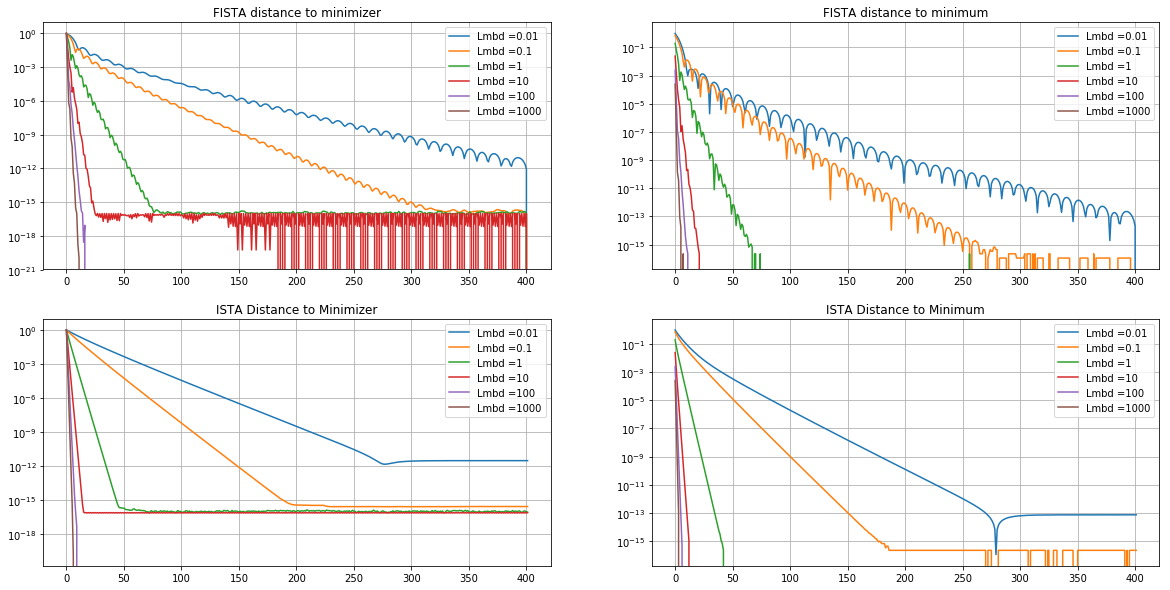

In [21]:
##Compariston of different values of Lamda##
def f_linreg(x):
    """Least squares loss"""
    return (0.5/n_samples)*np.linalg.norm(b-A@x,2)**2

def grad_f_linreg(x):
    """Least squares gradient"""
    return -(1/n_samples)*(np.transpose(A)@(b-A@x))

n_iter = 400
lamdas = [0.01,0.1,1,10,100,1000]

erreur_lin_FISTA = []
erreur_lin_ISTA = []
objec_lin_FISTA= []
objec_lin_ISTA = []

for i in range(len(lamdas)):
  steplin = 1/(smoothness_const_linreg(A))
  ##Linear Regression
  x_min_lin, obj_lin, err_lin = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lamdas[i], n_iter, x_true=coefs, verbose=False)
  x_min_lin_1, obj_lin_1, err_lin_1 = PGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lamdas[i], n_iter, x_true=x_min_lin, verbose=False)
  x_min_lin_2, obj_lin_2, err_lin_2 = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lamdas[i], n_iter, x_true=x_min_lin, verbose=False)
  erreur_lin_ISTA.append(err_lin_1)
  erreur_lin_FISTA.append(err_lin_2)
  objec_lin_FISTA.append(abs(obj_lin_2-obj_lin[-1]))
  objec_lin_ISTA.append(abs(obj_lin_1-obj_lin[-1]))

plt.figure(figsize = [20,10])
plt.subplot(2,2,1)
plt.grid()
plt.title("FISTA distance to minimizer")
for i in range(len(lamdas)):
  plt.semilogy(erreur_lin_FISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

plt.subplot(2,2,2)
plt.grid()
plt.title("FISTA distance to minimum")
for i in range(len(lamdas)):
  plt.semilogy(objec_lin_FISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

plt.subplot(2,2,3)
plt.grid()
plt.title("ISTA Distance to Minimizer")
for i in range(len(lamdas)):
  plt.semilogy(erreur_lin_ISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

plt.subplot(2,2,4)
plt.grid()
plt.title("ISTA Distance to Minimum")
for i in range(len(lamdas)):
  plt.semilogy(objec_lin_ISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

On the above plots we can observe that the bigger the level of the L2 penalization is, the faster both algorithms converge. This is not a surprise as the more we penalize the more we restrict the values of the minimizer to a smaller area centered at zero. So for very large values of lambda we will restrict the minimum to almost zero.  

**Comparison of the L1 and L2 penalty for both algorithms (Linear Regression)**

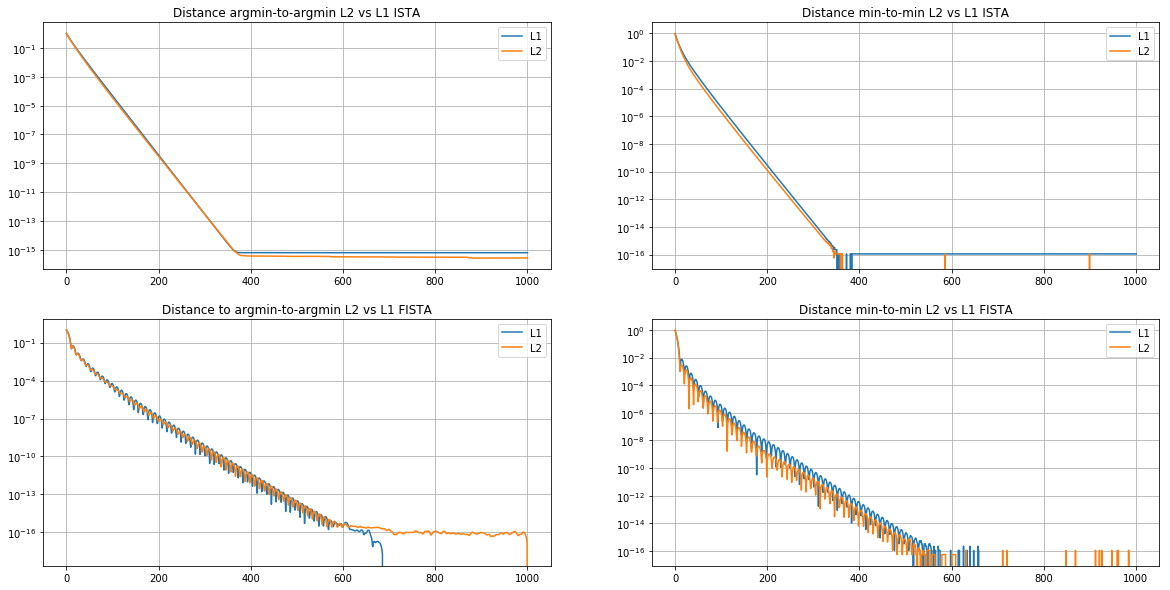

In [22]:
##In linear regression , compare the performance of the optimization algorithms for L2 and L1 penalizations. Explain##
n_iter = 1000
lmbd=1e-2
#### LINEAR REGRESSION ####


## L1 PEN ##
xx,oo,ee=APGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=coefs, verbose=False)
xx1, oo1,ee1 = PGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=xx, verbose=False)
xx2, oo2,ee2 = APGD(x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, steplin, lmbd, n_iter, x_true=xx, verbose=False)

## L2 PEN ##
xx_L2,oo_L2,ee_L2=APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=coefs, verbose=False)
xx1_L2, oo1_L2,ee1_L2 = PGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=xx_L2, verbose=False)
xx2_L2, oo2_L2,ee2_L2 = APGD(x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, steplin, lmbd, n_iter, x_true=xx_L2, verbose=False)


### PLOTS ###
## ISTA LINEAR
plt.figure(figsize=[20,10])
plt.subplot(2,2,1)
plt.grid()
plt.title("Distance argmin-to-argmin L2 vs L1 ISTA")
plt.semilogy(ee1,label="L1")
plt.semilogy(ee1_L2,label="L2")
plt.legend()

plt.subplot(2,2,2)
plt.grid()
plt.title("Distance min-to-min L2 vs L1 ISTA")
plt.semilogy(abs(oo1-oo[-1]),label="L1")
plt.semilogy(abs(oo1_L2-oo_L2[-1]),label="L2")
plt.legend()
##FISTA Linear Regression## 
##Comparison L1 and L2## 
plt.subplot(2,2,3)
plt.grid()
plt.title("Distance to argmin-to-argmin L2 vs L1 FISTA")
plt.semilogy(ee2,label="L1")
plt.semilogy(ee2_L2,label="L2")
plt.legend()
##Distance of Objective Function between L1 and L2##
plt.subplot(2,2,4)
plt.grid()
plt.title("Distance min-to-min L2 vs L1 FISTA")
plt.semilogy(abs(oo2-oo[-1]),label="L1")
plt.semilogy(abs(oo2_L2-oo_L2[-1]),label="L2")
plt.legend()

We observe that the performance of the algorithms is the same in the case of the L1 penalization and the L2 penalization as the error curves for the distance to the minimum and the argmins evolve in the same manner. 

**LOGISTIC REGRESSION**

We rerun the ISTA AND FISTA for both penalizations and then compare coefs and the minimas. The ISTA and FISTA algorithms for the logistic regression take a long time to execute.
**Do not forget to reset A,b to the logistic model and to re-execute f_logreg, grad_f_logreg and the step!!**

In [36]:
### RUN ALGORITHMS FOR LOGISTIC REGRESSION DO NOT FORGET TO RESET A and b #

### L1 PEN ###
xx_log_L1,oo_log_L1,ee_log_L1=APGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=coefs, verbose=False)
xx1_log_L1, oo1_log_L1,ee1_log_L1 = PGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=xx_log_L1, verbose=False)
xx2_log_L1, oo2_log_L1,ee2_log_L1 = APGD(x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=xx_log_L1, verbose=False)

### L2 PEN ###
xx_log, oo_log, ee_log = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=coefs, verbose=False)
xx1_log, oo1_log,ee1_log = PGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=xx_log, verbose=False)
xx2_log, oo2_log,ee2_log = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=xx_log, verbose=False)

**Comparison of the minimum obtained by the algorithms for each penalisation with the coefs**

(-2, 2)

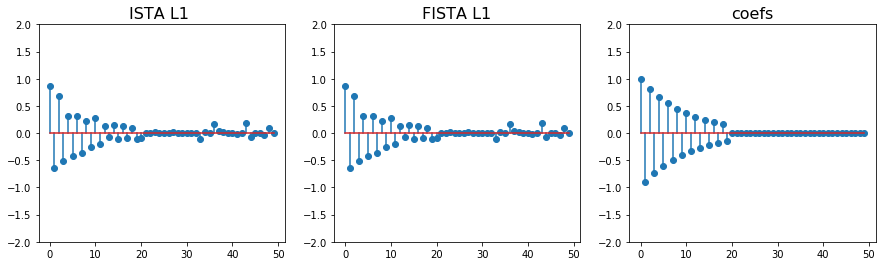

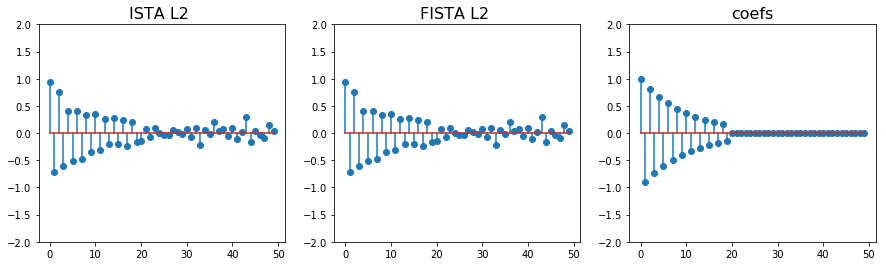

In [37]:
##Compare the solution you obtain with ista and fista with the true parameter `coefs` of the model. This can be done with `plt.stem` plots.##
## LOGISTIC REGRESSION ##
### COMPARISON OF COEFS WITH MINIMIZER FOR ISTA FISTA L1 PEN ###

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(xx1_log_L1)
plt.title("ISTA L1 ", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(xx2_log_L1)
plt.title("FISTA L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(coefs)
plt.title("coefs", fontsize=16)
plt.ylim([-2, 2])

### COMPARISON OF COEFS WITH MINIMIZER FOR ISTA/FISTA L2 PEN ###

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(xx1_log)
plt.title("ISTA L2 ", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(xx2_log)
plt.title("FISTA L2 ", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(coefs)
plt.title("coefs", fontsize=16)
plt.ylim([-2, 2])

As in the linear regression, we seem to approximate coeffs with a slight shrinkage. And we observe that the L1 penalization shrinks the minimizer more than the L2 penalization and better approximates the last 20 coordinates with values zero. 

**Now we evaluate the influence of the correlation of the features on the performance of the algorithms:**

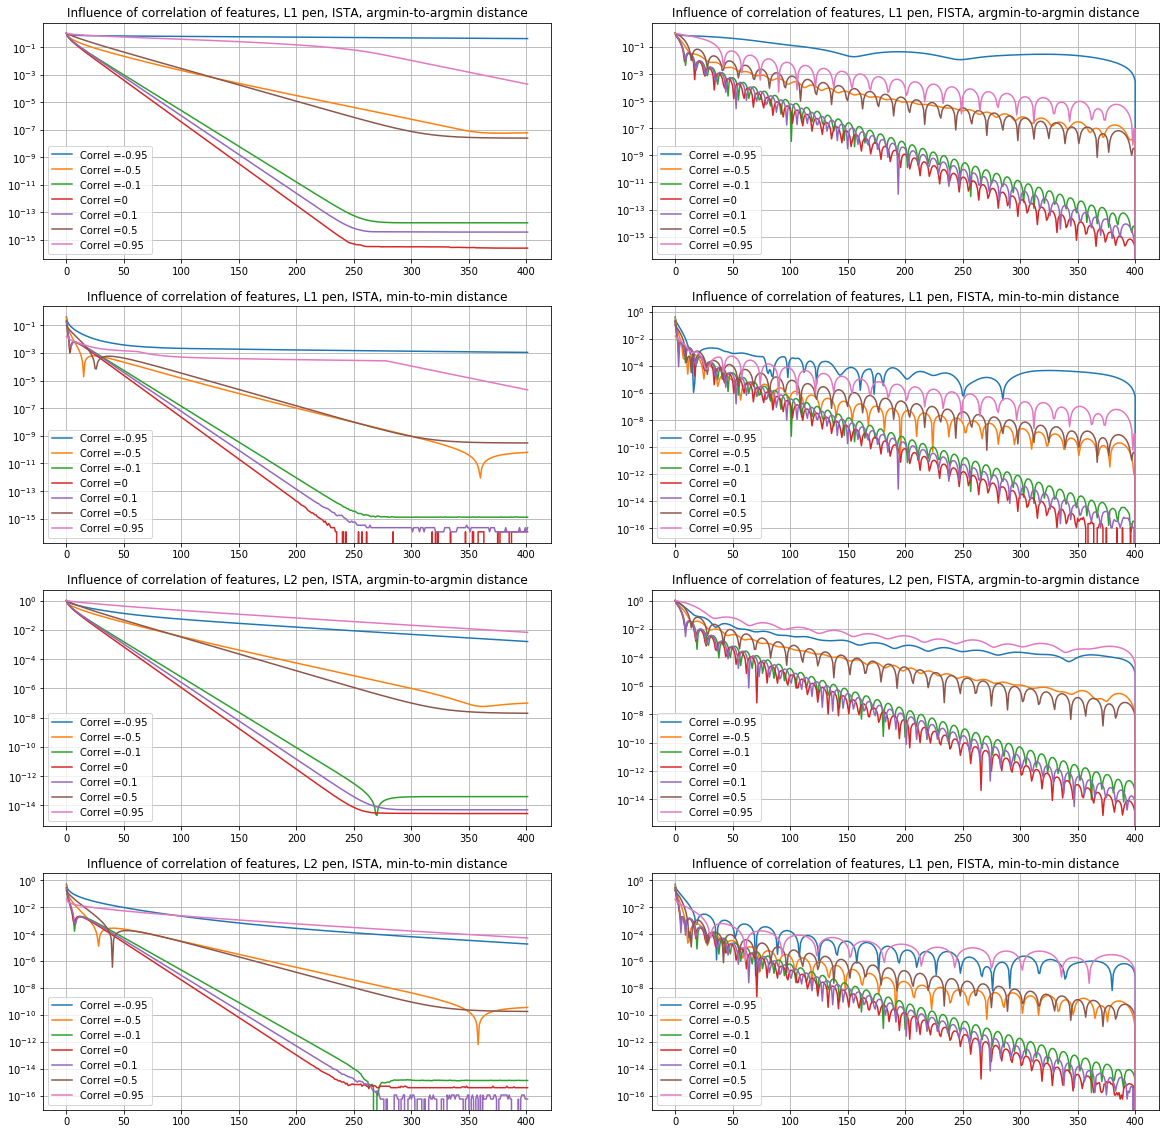

In [28]:
##In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.##
##logistic REGRESSION##
def f_logreg(x,A_,b_):
    """Logistic loss"""
    loss= 0
    for i in range(n_samples):
      loss += np.log(1+ np.exp(-b_[i]*(A_[i,:]@x)))
    return (1/n_samples)*loss

def grad_f_logreg(x,A_,b_):
    """Logistic gradient"""
    grad = np.zeros(n_features)
    for i in range(n_samples):
      grad += -(b_[i]*A_[i,:])*np.exp(-b_[i]*(A_[i,:]@x))/(1+np.exp(-b_[i]*(A_[i,:]@x)))
    return (1/n_samples)*grad

#corre = np.linspace(0.05,0.95,9)

corre = [-0.95, -0.5 ,-0.1,0, 0.1 , 0.5 , 0.95]
x0 = np.zeros(n_features)
n_iter = 400
lmbd = 1e-2
erreur_log_ISTA = [] 
erreur_log_FISTA = []
objec_log_FISTA = []
objec_log_ISTA = []


erreur_log_ISTA_L2 = [] 
erreur_log_FISTA_L2 = []
objec_log_FISTA_L2 = []
objec_log_ISTA_L2 = []


## COMPARISON OF CORREL INFLUENCE FOR L1 PENALIZATION 
for i in range(len(corre)):
  x0 = np.zeros(n_features)
  A_log, b_log = simu_logreg(coefs,corr=corre[i])
  steplog = 1/(smoothness_const_loreg(A_log)) 
  x_min_log, obj_log, err_log = APGD(x0, lambda fx:f_logreg(fx,A_log,b_log), lambda gradx:grad_f_logreg(gradx,A_log,b_log), L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=coefs, verbose=False)
  x_min_log_1, obj_log_1, err_log_1 = PGD(x0, lambda fx:f_logreg(fx,A_log,b_log), lambda gradx:grad_f_logreg(gradx,A_log,b_log), L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=x_min_log, verbose=False)
  x_min_log_2, obj_log_2, err_log_2 = APGD(x0, lambda fx:f_logreg(fx,A_log,b_log), lambda gradx:grad_f_logreg(gradx,A_log,b_log), L1_pen, prox_L1, steplog, lmbd, n_iter, x_true=x_min_log, verbose=False)
  erreur_log_ISTA.append(err_log_1)
  erreur_log_FISTA.append(err_log_2)
  objec_log_FISTA.append(abs(obj_log_2-obj_log[-1]))
  objec_log_ISTA.append(abs(obj_log_1-obj_log[-1]))


  x_min_log_L2, obj_log_L2, err_log_L2 = APGD(x0, lambda fx:f_logreg(fx,A_log,b_log), lambda gradx:grad_f_logreg(gradx,A_log,b_log), L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=coefs, verbose=False)
  x_min_log_1_L2, obj_log_1_L2, err_log_1_L2 = PGD(x0, lambda fx:f_logreg(fx,A_log,b_log), lambda gradx:grad_f_logreg(gradx,A_log,b_log), L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=x_min_log_L2, verbose=False)
  x_min_log_2_L2, obj_log_2_L2, err_log_2_L2 = APGD(x0, lambda fx:f_logreg(fx,A_log,b_log), lambda gradx:grad_f_logreg(gradx,A_log,b_log), L2_pen, prox_L2, steplog, lmbd, n_iter, x_true=x_min_log_L2, verbose=False)
  erreur_log_ISTA_L2.append(err_log_1_L2)
  erreur_log_FISTA_L2.append(err_log_2_L2)
  objec_log_FISTA_L2.append(abs(obj_log_2_L2-obj_log_L2[-1]))
  objec_log_ISTA_L2.append(abs(obj_log_1_L2-obj_log_L2[-1]))


plt.figure(figsize = [20,20])
plt.subplot(4,2,1)
plt.grid()
plt.title("Influence of correlation of features, L1 pen, ISTA, argmin-to-argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_log_ISTA[i],label = "Correl =" + str(corre[i]))
plt.legend()


plt.subplot(4,2,2)
plt.grid()
plt.title("Influence of correlation of features, L1 pen, FISTA, argmin-to-argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_log_FISTA[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,3)
plt.grid()
plt.title("Influence of correlation of features, L1 pen, ISTA, min-to-min distance")
for i in range(len(corre)):
  plt.semilogy(objec_log_ISTA[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,4)
plt.grid()
plt.title("Influence of correlation of features, L1 pen, FISTA, min-to-min distance")
for i in range(len(corre)):
  plt.semilogy(objec_log_FISTA[i],label = "Correl =" + str(corre[i]))
plt.legend() 



## COMPARISON OF CORREL INFLUENCE FOR L2 PENALIZATION 


plt.subplot(4,2,5)
plt.grid()
plt.title("Influence of correlation of features, L2 pen, ISTA, argmin-to-argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_log_ISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend()

plt.subplot(4,2,6)
plt.grid()
plt.title("Influence of correlation of features, L2 pen, FISTA, argmin-to-argmin distance")
for i in range(len(corre)):
  plt.semilogy(erreur_log_FISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,7)
plt.grid()
plt.title("Influence of correlation of features, L2 pen, ISTA, min-to-min distance")
for i in range(len(corre)):
  plt.semilogy(objec_log_ISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend() 

plt.subplot(4,2,8)
plt.grid()
plt.title("Influence of correlation of features, L1 pen, FISTA, min-to-min distance")
for i in range(len(corre)):
  plt.semilogy(objec_log_FISTA_L2[i],label = "Correl =" + str(corre[i]))
plt.legend() 





Again, as in the linear regression case, we observe that both FISTA and ISTA converge faster for features with correlations close to 0 and that the more the correlation of the features increases, the longer it takes for the algorithms to get close to the minimum. This is probably because with high correlation, the correlation matrix gets closer to a non invertible matrix.

**Influence of the level of L2 penalisation on the performance of ISTA and FISTA:**

In [29]:

def f_logreg(x):
    """Logistic loss"""
    loss= 0
    for i in range(n_samples):
      loss += np.log(1+ np.exp(-b[i]*(A[i,:]@x)))
    return (1/n_samples)*loss

def grad_f_logreg(x):
    """Logistic gradient"""
    grad = np.zeros(n_features)
    for i in range(n_samples):
      grad += -(b[i]*A[i,:])*np.exp(-b[i]*(A[i,:]@x))/(1+np.exp(-b[i]*(A[i,:]@x)))
    return (1/n_samples)*grad

##In linear regression and logistic regression, study the influence of the level of L2 penalization on the performance of the optimization algorithms. Explain.##
### LAMBDA INFLUENCE 
n_iter = 400
lamdas = [0.01,0.1,1,10,100,1000]

erreur_log_FISTA = []
erreur_log_ISTA = []
objec_log_FISTA= []
objec_log_ISTA = []

for i in range(len(lamdas)):
  steplog = 1/(smoothness_const_loreg(A))
  x_min_log, obj_log, err_log = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lamdas[i], n_iter, x_true=coefs, verbose=False)
  x_min_log_1, obj_log_1, err_log_1 = PGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lamdas[i], n_iter, x_true=x_min_log, verbose=False)
  x_min_log_2, obj_log_2, err_log_2 = APGD(x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, steplog, lamdas[i], n_iter, x_true=x_min_log, verbose=False)
  erreur_log_ISTA.append(err_log_1)
  erreur_log_FISTA.append(err_log_2)
  objec_log_FISTA.append(abs(obj_log_2-obj_log[-1]))
  objec_log_ISTA.append(abs(obj_log_1-obj_log[-1]))


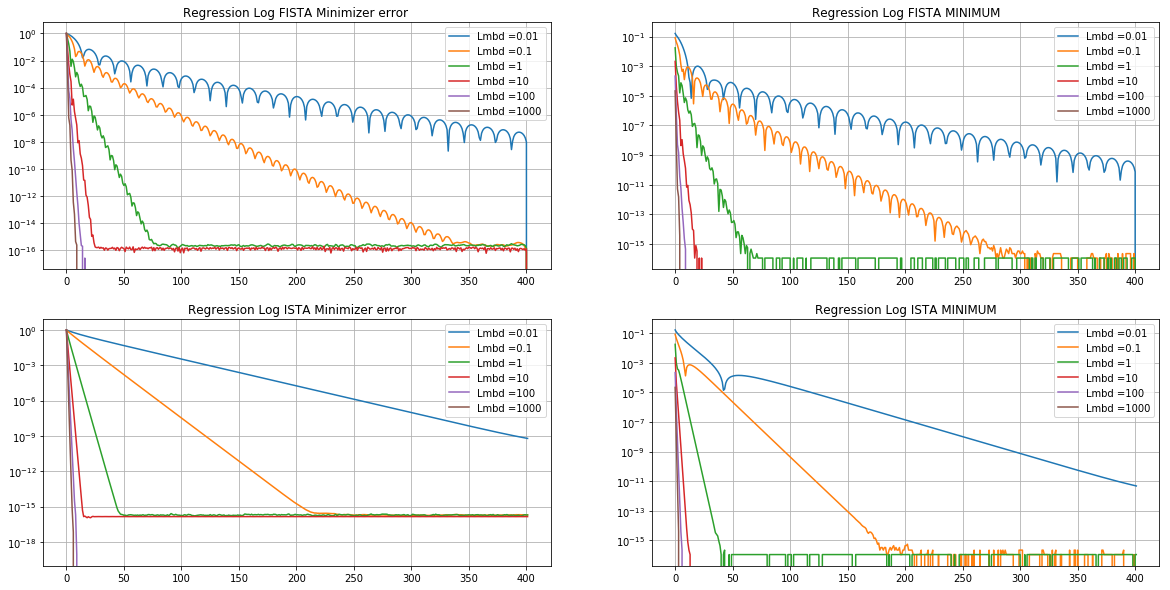

In [30]:
##Compariston of different values of Lamda
plt.figure(figsize=[20,10])
plt.subplot(2,2,1)
plt.grid()
plt.title("Regression Log FISTA Minimizer error ")
for i in range(len(lamdas)):
  plt.semilogy(erreur_log_FISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

plt.subplot(2,2,2)
plt.grid()
plt.title("Regression Log FISTA MINIMUM")
for i in range(len(lamdas)):
  plt.semilogy(objec_log_FISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

plt.subplot(2,2,3)
plt.grid()
plt.title("Regression Log ISTA Minimizer error")
for i in range(len(lamdas)):
  plt.semilogy(erreur_log_ISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()


plt.subplot(2,2,4)
plt.grid()
plt.title("Regression Log ISTA MINIMUM")
for i in range(len(lamdas)):
  plt.semilogy(objec_log_ISTA[i],label="Lmbd ="+str(lamdas[i]))
plt.legend()

As in the case of the linear regression, the more we penalize the faster the algorithms converge. For the same reasons as before. 

**Comparison of performance between L1 and L2 penalization:**

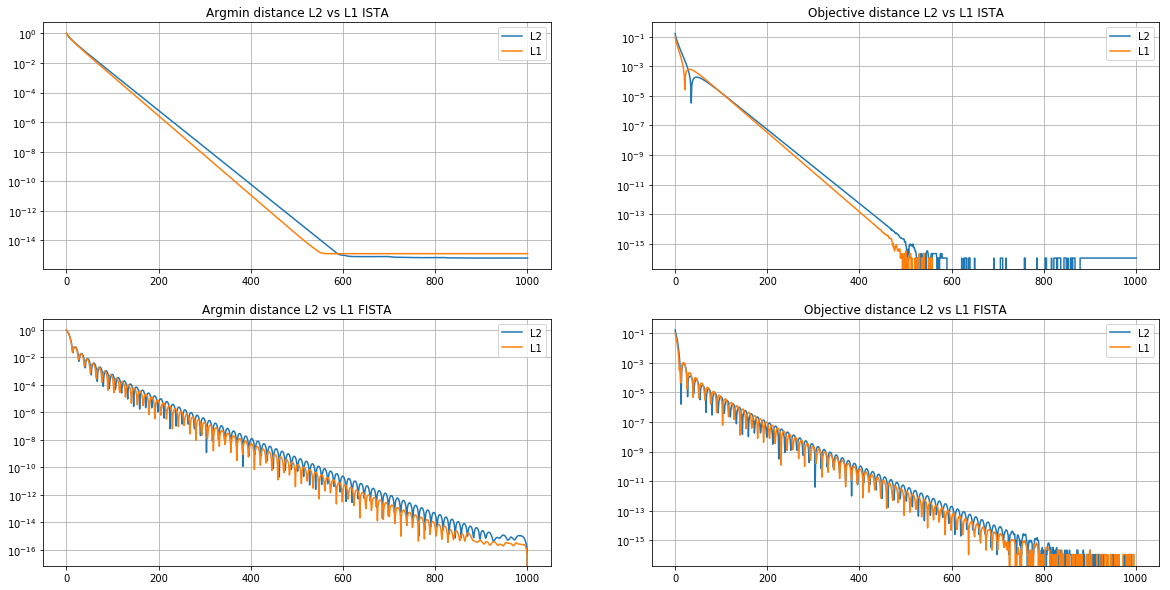

In [38]:
##In linear regression and logistic regression, compare the performance of the optimization algorithms for L2 and L1 penalizations. Explain##
## ISTA LOGISTIC
plt.figure(figsize = [20,10])
plt.subplot(2,2,1)
plt.grid()
plt.title("Argmin distance L2 vs L1 ISTA")
plt.semilogy(ee1_log,label="L2")
plt.semilogy(ee1_log_L1,label="L1")
plt.legend()

plt.subplot(2,2,2)
plt.grid()
plt.title("Objective distance L2 vs L1 ISTA")
plt.semilogy(abs(oo1_log-oo_log[-1]),label="L2")
plt.semilogy(abs(oo1_log_L1-oo_log_L1[-1]),label="L1")
plt.legend()

##FISTA Logistic Regression## 
##Comparison L1 and L2## 
plt.subplot(2,2,3)
plt.grid()
plt.title("Argmin distance L2 vs L1 FISTA")
plt.semilogy(ee2_log,label="L2")
plt.semilogy(ee2_log_L1,label="L1")
plt.legend()

##Distance of Objective Function between L1 and L2##
plt.subplot(2,2,4)
plt.grid()
plt.title("Objective distance L2 vs L1 FISTA")
plt.semilogy(abs(oo2_log-oo_log[-1]),label="L2")
plt.semilogy(abs(oo2_log_L1-oo_log_L1[-1]),label="L1")
plt.legend()

Again, as in the linear regression the penalization doesn't seem to affect the performance of the algorithms. 